# Multi task learning - baseline models

Start by importing stuff:

Install as:
```
uv add pandas torch matplotlib seaborn numpy scikit-learn pytorch_lightning
```

In [1]:
import pandas as pd

import torch
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")


Let's generate some data.
We will build a common latent space and multiple outputs that build from that.
We need some non-linearity otherwise we will just end up with each output being a linear combination of features.


Data is generated as follows:

x -> x_l
x_l -> y_0
x_l -> y_1


In [2]:
import numpy as np


def create_dummy_data(
    n_samples: int = 1_000,
    x_dim: int = 20,
    l_dim: int = 10,
    y_dim: int = 5,
    noise_level: float = 1.0,
    seed: int = None,
):
    rnd = np.random.default_rng(seed=seed)

    # create random features
    x = rnd.uniform(-1, 1, size=(n_samples, x_dim))

    # create random latent space
    w_l = rnd.uniform(-1, 1, size=(x_dim, l_dim))
    x_l = np.dot(x, w_l)

    # create outputs from latent space
    w_y = rnd.uniform(-1, 1, size=(l_dim, y_dim))
    y = np.dot(x_l, w_y) + noise_level * rnd.normal(size=(n_samples,y_dim))

    return {
        "x": x,
        "y": y,
        "col_reg": list(range(y_dim)),
        "col_class": [],
        "x_l": x_l,
        "w_l": w_l,
        "w_y": w_y,
    }


# # create outputs from latent space
# w_0 = np.random.uniform(-1, 1, size=(l_dim, 1))
# y_0 = np.dot(x_l, w_0) + np.random.normal(size=(n,1))
# y_1 = ((y_0 + np.random.normal(size=(n,1)))>-5.0)*1.0
# y_2 = ((y_0 + np.random.normal(size=(n,1)))>0.5)*1.0
# y_3 = ((y_0 + np.random.normal(size=(n,1)))>5.0)*1.0
# y_4 = ((y_0 + np.random.normal(size=(n,1)))>8.0)*1.0

# y = np.hstack([y_0, y_1, y_2, y_3, y_4])

# # specify outcome types
# col_reg = [0]
# col_class = [1, 2, 3]

# y.mean(axis=0)


dummy_data = create_dummy_data(n_samples=10_000, x_dim=20, l_dim=10, seed=None, noise_level=1.0)
dummy_data.keys()


dict_keys(['x', 'y', 'col_reg', 'col_class', 'x_l', 'w_l', 'w_y'])

## Train models

In [3]:
models = {}
y_train_est = {}
y_test_est = {}


Split train/test

In [4]:
def split_data(dummy_data):
    n = dummy_data["x"].shape[0]
    x_train = dummy_data["x"][: n // 2]
    x_test = dummy_data["x"][n // 2 :]
    y_train = dummy_data["y"][: n // 2]
    y_test = dummy_data["y"][n // 2 :]

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_data(dummy_data)

In [5]:
def train_sklearn_model(x_train, x_test, y_train, col_reg, col_class, model_reg, model_class):
    models = []
    y_train_est = []
    y_test_est = []
    for _col in range(y_train.shape[1]):
        print(y_train[:, _col].shape)
        if _col in col_reg:
            _model = model_reg()
            _model.fit(x_train, y_train[:, _col])
            _y_train_est = _model.predict(x_train)
            _y_test_est = _model.predict(x_test)

        elif _col in col_class:
            _model = model_class()
            _model.fit(x_train, y_train[:, _col])
            _y_train_est = _model.predict_proba(x_train)[:, 1]
            _y_test_est = _model.predict_proba(x_test)[:, 1]
        y_train_est.append(_y_train_est)
        y_test_est.append(_y_test_est)
        models.append(_model)

    y_train_est = np.stack(y_train_est).transpose()
    y_test_est = np.stack(y_test_est).transpose()


    return models, y_train_est, y_test_est


### Linear models

In [6]:
import sklearn.linear_model

models["linear"], y_train_est["linear"], y_test_est["linear"] = train_sklearn_model(
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    col_reg=dummy_data["col_reg"],
    col_class=dummy_data["col_class"],
    model_reg=sklearn.linear_model.LinearRegression,
    model_class=sklearn.linear_model.LogisticRegression,
)


(5000,)
(5000,)
(5000,)
(5000,)
(5000,)


### GBMs

Fit GBMs to each output

In [7]:
import sklearn.ensemble

models["gbm"], y_train_est["gbm"], y_test_est["gbm"] = train_sklearn_model(
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    col_reg=dummy_data["col_reg"],
    col_class=dummy_data["col_class"],
    model_reg=sklearn.ensemble.GradientBoostingRegressor,
    model_class=sklearn.ensemble.GradientBoostingClassifier,
)


(5000,)
(5000,)
(5000,)
(5000,)
(5000,)


## Train multi-task neural net

Next we prep data for PyTorch by converting to Tensors and
creating dataloaders.

We need to use the whole dataset in each step rather than smaller batches to match the way
sklearn has it's cost function setup.

In [8]:
import torch.utils.data


def dataloader_from_dummy_data(x_train, y_train, x_test, y_test):
    x_train_t = torch.Tensor(x_train)
    y_train_t = torch.Tensor(y_train)
    x_test_t = torch.Tensor(x_test)
    y_test_t = torch.Tensor(y_test)

    dataset_train = torch.utils.data.TensorDataset(x_train_t, y_train_t)
    dataloader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=x_train_t.shape[0], shuffle=True
    )
    dataset_test = torch.utils.data.TensorDataset(x_test_t, y_test_t)
    dataloader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=x_test_t.shape[0], shuffle=True
    )

    return dataloader_train, dataloader_test

dataloader_train, dataloader_test = dataloader_from_dummy_data(x_train, y_train, x_test, y_test)

### Model definition

Each output head should output a distribution so that we can measure the loglikelihood.
Or each output head should output a scalar.

In [9]:
import pytorch_lightning as pl
import torch


def get_dense_mlp(layer_size: list[int]) -> torch.nn.Sequential:
    """
    Builds pairs of (Linear, Relu) and a final Linear.
    """

    dense_layers = []
    for _idx in range(len(layer_size) - 2):
        dense_layers.append(torch.nn.Linear(layer_size[_idx], layer_size[_idx + 1]))
        dense_layers.append(torch.nn.ReLU())
    return torch.nn.Sequential(
        *dense_layers, torch.nn.Linear(layer_size[-2], layer_size[-1])
    )


def get_output_head_layers(emb_size: int, col_type: str):
    # general output head layers
    output_layers = get_dense_mlp([emb_size, 4, 1])
    return output_layers

    if 0:
        # outcome specific layer
        if col_type == "reg":
            return torch.nn.Sequential(
                *output_layers, torch.nn.Linear(output_size[-1], 1)
            )

            # mean = self.mean_linear(outputs)
            # scale = torch.nn.functional.softplus(self.scale_linear(outputs))
        if col_type == "class":
            return torch.nn.Sequential(
                *output_layers, torch.nn.Linear(output_size[-1], 1)
            )


class MLTNN(pl.LightningModule):
    def __init__(
        self,
        col_reg: list[int],
        col_class: list[int],
        n_inputs: int = 1,
        learning_rate=0.05,
    ):
        super().__init__()

        self.learning_rate = learning_rate
        self.train_log = []
        self.val_log = []

        n_outputs = max(col_reg + col_class) + 1
        self.loss_fcns = []
        for _idx in range(n_outputs):
            if _idx in col_reg:
                self.loss_fcns.append(torch.nn.MSELoss())
            if _idx in col_class:
                self.loss_fcns.append(torch.nn.BCEWithLogitsLoss())

        # embedding
        emb_size = 8
        self.embedding = get_dense_mlp([n_inputs, 64, 32, 16, emb_size])

        # output head for each output
        self.output_heads = []
        n_outputs = max(col_reg + col_class) + 1
        for _idx in range(n_outputs):
            self.output_heads.append(get_dense_mlp([emb_size, 1]))

            # _output_layers = _get_output_head_layers(col_type="reg" if _idx in col_reg else "class")
            # self.output_heads.append(_output_layers)

    def forward(self, x):
        emb = self.embedding(x)
        return torch.concat(
            [_output_head(emb) for _output_head in self.output_heads], dim=1
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx=None):
        x, y = batch
        y_hat = self(x)

        loss = torch.tensor(0.0)
        losses = []
        for _idx, _loss in enumerate(self.loss_fcns):
            losses.append(_loss(y_hat[:, _idx], y[:, _idx]))
            loss += losses[-1]

        self.log("loss", loss)
        self.train_log.append([_loss.detach().numpy() for _loss in losses])
        return loss

    def validation_step(self, batch, batch_idx=None):
        x, y = batch
        y_hat = self(x)

        loss = torch.tensor(0.0)
        losses = []
        for _idx, _loss in enumerate(self.loss_fcns):
            losses.append(_loss(y_hat[:, _idx], y[:, _idx]))
            loss += losses[-1]

        self.log("val_loss", loss)
        self.val_log.append([_loss.detach().numpy() for _loss in losses])

        return loss


def plot_convergence(train_loss):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_loss)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Train loss")
    fig.show()


def loss_fn_loglike(y_hat, y):
    negloglik = -y_hat.log_prob(y)
    return torch.mean(negloglik)


model = MLTNN(
    n_inputs=dummy_data["x"].shape[1],
    col_reg=dummy_data["col_reg"],
    col_class=dummy_data["col_class"],
)
model.output_heads
model


MLTNN(
  (embedding): Sequential(
    (0): Linear(in_features=20, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
  )
)

In [10]:
model(x_train_t)
x_batch, y_batch = next(iter(dataloader_train))
model.training_step((x_batch, y_batch))


NameError: name 'x_train_t' is not defined

In [11]:
# fit model
trainer = pl.Trainer(max_epochs=200, accelerator="cpu")
trainer.fit(model, dataloader_train, dataloader_test)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/rich/Developer/Github/VariousDataAnalysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/rich/Developer/Github/VariousDataAnalysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | embedding |

/Users/rich/Developer/Github/VariousDataAnalysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/rich/Developer/Github/VariousDataAnalysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/rich/Developer/Github/VariousDataAnalysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/rich/Developer/Github/Var

Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  8.88it/s, v_num=21]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s, v_num=21]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_86301/2872451964.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


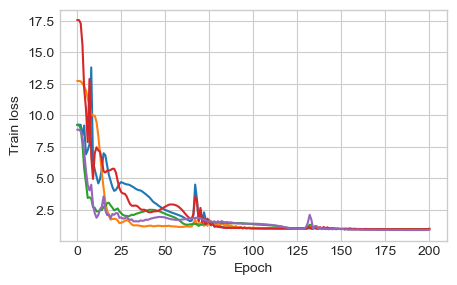

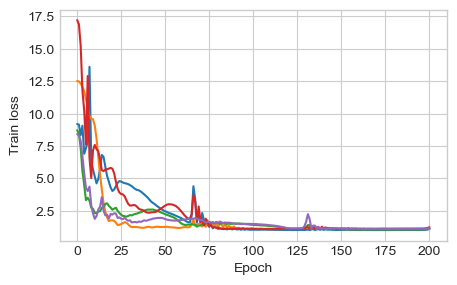

In [12]:
plot_convergence(model.train_log)
plot_convergence(model.val_log)


Get outputs for comparison

Take `expit` of the model outputs for classifiers.

In [13]:
_y_est = model(x_train_t)
_y_est[:, dummy_data["col_class"]] = torch.sigmoid(_y_est[:, dummy_data["col_class"]])
y_train_est["mltnn"] = _y_est.detach().numpy()

_y_est = model(x_test_t)
_y_est[:, dummy_data["col_class"]] = torch.sigmoid(_y_est[:, dummy_data["col_class"]])
y_test_est["mltnn"] = _y_est.detach().numpy()


Check:
* model weights vary between the output heads
* embedding is training

## Evaluation

In [25]:
import sklearn.metrics

train_loss = {}
test_loss = {}
for _name, val in y_train_est.items():
    train_loss[_name] = []
    for _col in range(max(dummy_data["col_reg"] + dummy_data["col_class"]) + 1):
        if _col in dummy_data["col_reg"]:
            train_loss[_name].append(
                sklearn.metrics.mean_squared_error(
                    y_train[:, _col], y_pred=val[:, _col]
                )
            )
        elif _col in dummy_data["col_class"]:
            train_loss[_name].append(
                sklearn.metrics.log_loss(y_train[:, _col], y_pred=val[:, _col])
            )

for _name, val in y_test_est.items():
    test_loss[_name] = []
    for _col in range(max(dummy_data["col_reg"] + dummy_data["col_class"]) + 1):
        if _col in dummy_data["col_reg"]:
            test_loss[_name].append(
                sklearn.metrics.mean_squared_error(y_test[:, _col], y_pred=val[:, _col])
            )
        elif _col in dummy_data["col_class"]:
            test_loss[_name].append(
                sklearn.metrics.log_loss(y_test[:, _col], y_pred=val[:, _col])
            )

# print("train loss")
# display(train_loss)
# print("test loss")
# display(test_loss)

results = pd.concat(
    [
        pd.DataFrame(train_loss).assign(mode="train"),
        pd.DataFrame(test_loss).assign(mode="test"),
    ]
).reset_index(names='y_dim')
results

,y_dim,linear,gbm,mltnn,mode
0,0,1.002778,1.149909,1.016966,train
1,1,1.004343,1.300029,0.915769,train
2,2,0.985115,1.209995,0.977741,train
3,3,1.031973,1.616811,1.049662,train
4,4,0.949022,1.057741,0.916175,train
5,0,0.972437,1.785862,1.106434,test
6,1,1.002757,2.014625,1.096438,test
7,2,1.015170,1.886594,1.132457,test
8,3,1.028204,2.633266,1.239510,test
9,4,1.032819,1.709747,1.158248,test


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_86301/110782121.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


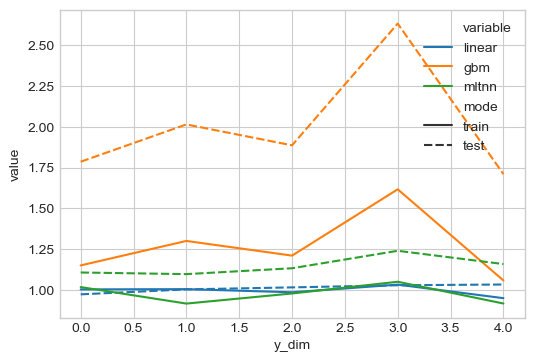

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=results.melt(id_vars=["y_dim", "mode"]),
    x="y_dim",
    y="value",
    hue="variable",
    style="mode",
    ax=ax,
)
fig.show()


# Todo
* Show within https://netron.app/?url=https://media.githubusercontent.com/media/onnx/models/main/vision/classification/squeezenet/model/squeezenet1.0-3.onnx

In [ ]:
dummy_input = torch.randn(10, 20)
input_names = ["actual_input_1"] + ["learned_%d" % i for i in range(20)]
output_names = ["output_%d" % i for i in range(4)]

torch.onnx.export(
    model,
    dummy_input,
    "multitask.onnx",
    verbose=True,
    input_names=input_names,
    output_names=output_names,
)


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



RuntimeError: Cannot insert a Tensor that requires grad as a constant. Consider making it a parameter or input, or detaching the gradient
Tensor:
 0.3519 -0.2375 -0.0612  0.1224  0.1569  0.0826  0.2925  0.0338
[ torch.FloatTensor{1,8} ]